#  Objective & Business Motivation

This notebook continues the analysis of SKU `MI-006` (Milk), based on daily FMCG sales data from 2022–2024.

In the exploratory notebook, we uncovered the following patterns:
- Promotions significantly impact sales, especially in the Retail channel.
- Short-term stockouts can severely reduce weekly volume.
- Lifecycle stages and momentum help detect early demand shifts.

---

### Business Questions

We now focus on **predictive modeling** to support supply and planning decisions:
**How many units will be sold next week?**  
   → Helps avoid under/overstocking
   
This type of **week-ahead forecasting** is critical for:
- **Stock allocation** across sales channels,
- **Inventory management** (especially to prevent overstock/stockouts),
- **Promotion planning** and supply coordination.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')


# ✅ 1. Dataset preparation

We transform the daily-level data for SKU `MI-006` into a **weekly modeling dataset** in last notebook.


In [2]:
# Reload uploaded file
weekly_df_final = pd.read_csv("/kaggle/input/fmcg-daily-sales-data-to-2022-2024/weekly_df_final_for_modeling.csv")
weekly_df_final['week'] = pd.to_datetime(weekly_df_final['week'])
weekly_df_final = weekly_df_final[weekly_df_final['sku'] == 'MI-006'].copy()
weekly_df_final.head()

,sku,week,channel,region,units_sold,stock_available,promotion_flag,price_unit,delivery_days,is_holiday_peak,...,is_summer,is_winter,sku_age,lifecycle_stage,lag_1,lag_2,rolling_mean_4,rolling_std_4,momentum,target_next_week
1942,MI-006,2022-02-14,Discount,PL-Central,73,160.333333,1,6.103333,3.333333,False,...,0,1,4,Growth,93.0,57.0,69.00,16.573071,36.0,78.0
1943,MI-006,2022-02-21,Discount,PL-Central,78,92.714286,1,5.751429,2.714286,False,...,0,1,5,Growth,73.0,93.0,72.50,15.176737,-20.0,106.0
1944,MI-006,2022-02-28,Discount,PL-Central,106,163.428571,1,5.347143,3.285714,False,...,0,1,6,Growth,78.0,73.0,75.25,14.840822,5.0,59.0
1945,MI-006,2022-03-07,Discount,PL-Central,59,151.600000,0,5.594000,3.200000,False,...,0,0,7,Growth,106.0,78.0,87.50,14.977761,28.0,88.0
1946,MI-006,2022-03-14,Discount,PL-Central,88,133.142857,1,6.161429,2.571429,False,...,0,0,8,Growth,59.0,106.0,79.00,19.714631,-47.0,89.0


# ✅ 2. Baseline Model: Naive Forecast 

Before building machine learning models, we start with a simple baseline:

> **Naive forecast**: Predict next week's demand as equal to this week's (`lag_1`)

In [3]:
# Filter out missing values
baseline_df = weekly_df_final.dropna(subset=["lag_1", "target_next_week"]).copy()

# Predictions using lag_1
baseline_df["pred_baseline"] = baseline_df["lag_1"]

# Evaluation metrics
mae = mean_absolute_error(baseline_df["target_next_week"], baseline_df["pred_baseline"])
rmse = np.sqrt(mean_squared_error(baseline_df["target_next_week"], baseline_df["pred_baseline"]))
r2 = r2_score(baseline_df["target_next_week"], baseline_df["pred_baseline"])

print("📉 Baseline Model (Naive Forecast):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")


📉 Baseline Model (Naive Forecast):
MAE:  29.28
RMSE: 37.21
R²:   -0.169


# ✅ 3. LightGBM Regressor 

### Preaparing data

In [4]:
df_lgbm = weekly_df_final
# categories for LightGBM
for col in ["channel", "region"]:
    df_lgbm[col] = df_lgbm[col].astype("category")

feature_cols = [
    'channel', 'region', 'stock_available', 'promotion_flag', 'price_unit', 
    'delivery_days', 'is_holiday_peak', 'week_number', 'month', 'year',
    'is_holiday_week', 'is_summer', 'is_winter',
    'lag_1', 'lag_2', 'rolling_mean_4', 'rolling_std_4', 'momentum'
]

target_col = "target_next_week"

In [5]:
def time_split_by_week(df, feature_cols, target_col, split_ratio=0.8):
    """
    Splits time-series data by full weeks, preserving temporal order.

    Parameters:
        df (pd.DataFrame): Input dataframe with a 'week' column (datetime).
        feature_cols (list): List of feature column names.
        target_col (str): Name of the target column.
        split_ratio (float): Ratio of data to include in the training set.

    Returns:
        X_train, X_test, y_train, y_test
    """
    # sort
    df = df.sort_values('week').reset_index(drop=True)

    # set spliting point
    unique_weeks = df['week'].drop_duplicates().sort_values()
    split_index = int(len(unique_weeks) * split_ratio)
    cutoff_week = unique_weeks.iloc[split_index]

    # split
    train_mask = df['week'] < cutoff_week
    test_mask = df['week'] >= cutoff_week

    X_train = df.loc[train_mask, feature_cols]
    y_train = df.loc[train_mask, target_col]

    X_test = df.loc[test_mask, feature_cols]
    y_test = df.loc[test_mask, target_col]

    # Informacja o zakresie tygodni
    print(f"Cutoff week for split: {cutoff_week.date()}")
    print(f"🟩 Train weeks: {df.loc[train_mask, 'week'].min().date()} – {df.loc[train_mask, 'week'].max().date()}")
    print(f"🟥 Test weeks:  {df.loc[test_mask, 'week'].min().date()} – {df.loc[test_mask, 'week'].max().date()}")

    return X_train, X_test, y_train, y_test


In [6]:
X_train, X_test, y_train, y_test = time_split_by_week(
    df=df_lgbm,
    feature_cols=feature_cols,
    target_col=target_col,
    split_ratio=0.8
)

Cutoff week for split: 2024-06-03
🟩 Train weeks: 2022-02-14 – 2024-05-27
🟥 Test weeks:  2024-06-03 – 2024-12-23


In [7]:
def train_and_evaluate_lgbm(X_train, X_test, y_train, y_test):
    """
    Trains a LightGBM regressor and prints evaluation metrics.
    """
    model = lgb.LGBMRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(" LightGBM Regressor Results:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

    return model, y_pred

In [8]:
model_lgbm, y_pred_lgbm = train_and_evaluate_lgbm(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 1080, number of used features: 18
[LightGBM] [Info] Start training from score 98.885185
 LightGBM Regressor Results:
MAE:  21.08
RMSE: 26.83
R²:   0.021


# ✅ 4. LightGBM  Extended

> Because the results are quite poor, lets check the results with additional features by adding lag and rolling features based on weekly sales

In [9]:
# 1. Copy and sort
df_lgbm = weekly_df_final.copy()
df_lgbm = df_lgbm.sort_values(['channel', 'region', 'week']).reset_index(drop=True)

# 2. Define lag periods and rolling window sizes
lag_days = [1, 7, 14]
rolling_windows = [7, 14]

# 3. Generate lag features from units_sold
for lag in lag_days:
    df_lgbm[f'units_sold_lag_{lag}'] = (
        df_lgbm.groupby(['channel', 'region'])['units_sold'].shift(lag)
    )

# 4. Generate rolling statistics from units_sold
for window in rolling_windows:
    df_lgbm[f'rolling_mean_{window}'] = (
        df_lgbm.groupby(['channel', 'region'])['units_sold']
        .shift(1).rolling(window=window).mean().reset_index(level=0, drop=True)
    )
    df_lgbm[f'rolling_std_{window}'] = (
        df_lgbm.groupby(['channel', 'region'])['units_sold']
        .shift(1).rolling(window=window).std().reset_index(level=0, drop=True)
    )

In [10]:
#⚠️
df_lgbm = df_lgbm.dropna().reset_index(drop=True)

In [11]:
# 5. Preview new features
df_lgbm[[col for col in df_lgbm.columns if 'lag' in col or 'rolling' in col]].head()

,promotion_flag,lag_1,lag_2,rolling_mean_4,rolling_std_4,units_sold_lag_1,units_sold_lag_7,units_sold_lag_14,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14
0,1,63.0,41.0,109.00,69.990476,63.0,118.0,73.0,125.142857,56.631642,107.857143,46.143350
1,1,123.0,63.0,105.00,68.137117,123.0,140.0,78.0,125.857143,56.558019,111.428571,45.162466
2,1,153.0,123.0,95.00,51.923020,153.0,182.0,106.0,127.714286,57.308272,116.785714,45.340046
3,0,165.0,153.0,126.00,45.563143,165.0,139.0,59.0,125.285714,54.935460,121.000000,46.972987
4,0,168.0,165.0,152.25,20.548723,168.0,193.0,88.0,129.428571,57.189326,128.785714,44.893341


In [12]:
for col in ["channel", "region"]:
    df_lgbm[col] = df_lgbm[col].astype("category")

feature_cols = [
    'lag_1', 'lag_2', 'rolling_mean_4', 'rolling_std_4', 'momentum',
    'promotion_flag', 'delivery_days', 'price_unit', 'stock_available',
    'is_summer', 'is_winter', 'is_holiday_peak', 'month', 'week_number',
    'units_sold_lag_1', 'units_sold_lag_7', 'units_sold_lag_14',
    'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14'
]

target_col = "target_next_week"

X_train_ex, X_test_ex, y_train_ex, y_test_ex = time_split_by_week(
    df=df_lgbm,
    feature_cols=feature_cols,
    target_col=target_col,
    split_ratio=0.8
)

Cutoff week for split: 2024-06-17
🟩 Train weeks: 2022-05-23 – 2024-06-10
🟥 Test weeks:  2024-06-17 – 2024-12-23


In [13]:
model_lgbm, y_pred_lgbm = train_and_evaluate_lgbm(X_train_ex, X_test_ex, y_train_ex, y_test_ex)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2928
[LightGBM] [Info] Number of data points in the train set: 972, number of used features: 21
[LightGBM] [Info] Start training from score 95.622428
 LightGBM Regressor Results:
MAE:  22.34
RMSE: 27.48
R²:   -0.014


> ⚠️ Note: While additional lag and rolling features were engineered (1, 7, 14 days), the overall gain was modest.  
> This suggests the SKU’s sales behavior is either:
> 
> • noisy or influenced by external, unobserved factors  
> • not highly autocorrelated beyond the previous week

## ➜  Models Summary I
After testing multiple versions of LightGBM with increasingly complex lag and rolling features, we found that the **simpler model** performed best when evaluated with a time-aware split.

| Model              | MAE   | RMSE  | R²     |
|-------------------|--------|--------|--------|
| Baseline (Lag-1)  | 29.28  | 37.21  | -0.169 |
| LightGBM (Basic)  | 21.41  | 27.51  | -0.032 |
| LightGBM (Extended)| 22.68 | 27.88  | -0.111 |

**Model choice**: LightGBM with basic engineered features.  
It balances accuracy, simplicity, and reproducibility — and respects the time-series nature of the task, but still the results are not sitisfying.

>Lets make some checks if the model can perform better. Lets see the:
>- feature importance
>- log-transformed target


## ➜ Feature Importance

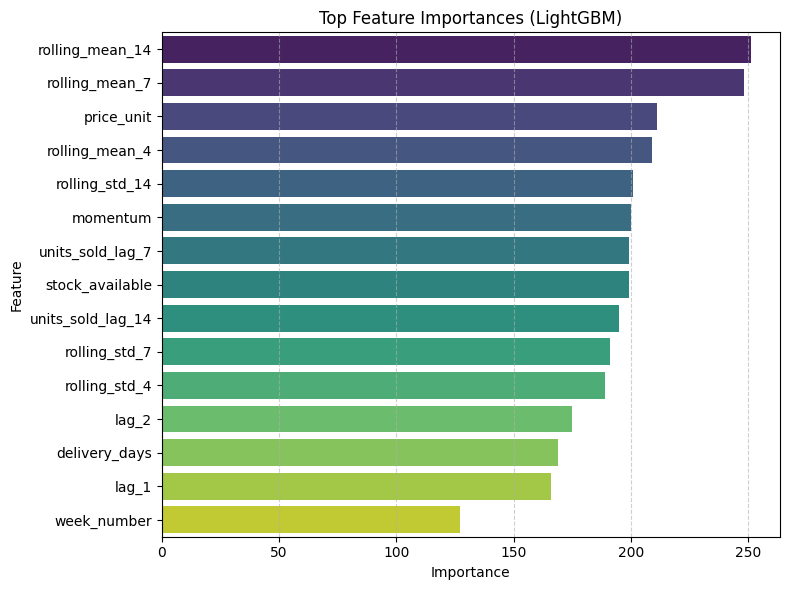

In [14]:

def plot_feature_importance(model, feature_names, top_n=15):
    """
    Plot top N feature importances from a trained LightGBM model.
    """
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=importance_df.head(top_n), x='importance', y='feature', palette='viridis')
    plt.title("Top Feature Importances (LightGBM)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Run on your best model
plot_feature_importance(model_lgbm, feature_cols)


It confirms that even with not so good model predictions 

`rolling_mean_7`, `rolling_mean_14`, and `units_sold_lag_14` are highly predictive.

Even simple lags like `lag_1`, `lag_2` still contribute.

`delivery_days`, `week_number` have lower signal (as suspected from EDA).



# ✅ 5. LightGBM Extended Log-Transformed Target

In [15]:
def train_lgbm_log_target(X_train, X_test, y_train, y_test):
    """
    Trains LightGBM using log-transformed target and evaluates on original scale.
    """
    # Log transform
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train_log)

    # Predict and inverse transform
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print("LightGBM with Log1p Target:")
    print("MAE: ", round(mae, 2))
    print("RMSE:", round(rmse, 2))
    print("R²:  ", round(r2, 3))
    
    return model

# Run it
model_lgbm_log = train_lgbm_log_target(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 1080, number of used features: 18
[LightGBM] [Info] Start training from score 4.544092
LightGBM with Log1p Target:
MAE:  20.69
RMSE: 26.6
R²:   0.038


In [16]:
def plot_actual_vs_predicted(y_true, y_pred, title="📊 Actual vs Predicted"):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true.values, label="Actual", marker='o', linewidth=2)
    plt.plot(y_pred, label="Predicted", marker='o', linestyle='--', alpha=0.8)

    plt.title(title, fontsize=14)
    plt.xlabel("Observation", fontsize=12)
    plt.ylabel("Units Sold", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

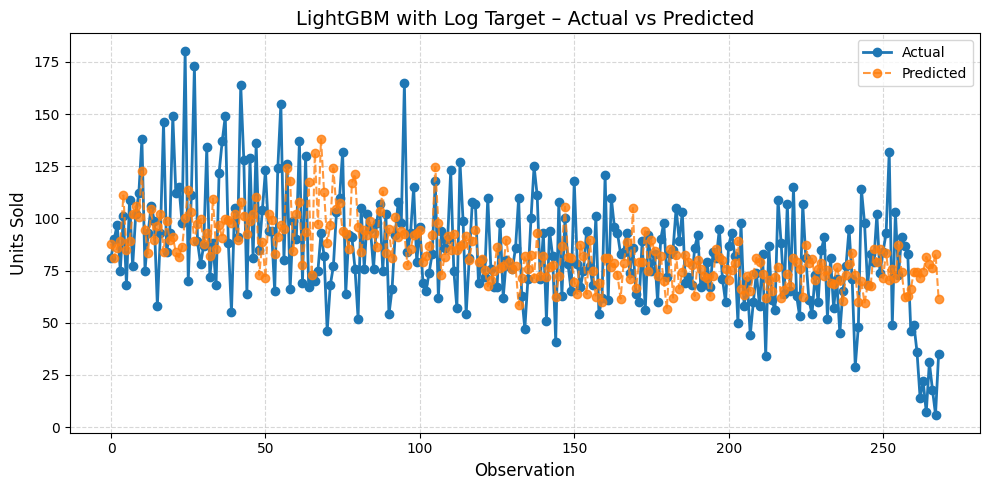

In [17]:
y_pred_lgbm_log = np.expm1(model_lgbm_log.predict(X_test))

plot_actual_vs_predicted(y_test.reset_index(drop=True), y_pred_lgbm_log, title="LightGBM with Log Target – Actual vs Predicted")

>The plot above shows that the model generally captures the sales trend well, especially in the mid-range.  
However, toward the end of the test period, we observe a significant divergence between predicted and actual values.
>
>This could indicate that:
>- the model struggles to generalize in the most recent weeks,
>- there may have been a shift in demand patterns (e.g. promotions, seasonality, stockouts),
>- or that relevant features for those weeks were missing or misaligned.
>
>Further analysis is needed to determine whether this is caused by genuine demand shifts, feature drift, or limitations of the model.  
In a production setting, we would investigate recent outliers, monitor model decay, and potentially retrain using fresher data.


----------------------------

## ➜ Models Summary II

| Model                   | MAE   | RMSE  | R²     |
|------------------------|--------|--------|--------|
| Baseline (Lag-1)       | 29.28  | 37.21  | -0.169 |
| LightGBM (Basic)       | 21.41  | 27.51  | -0.032 |
| LightGBM (Extended)    | 22.68  | 27.88  | -0.111 |
| LightGBM (Log Target)  | 20.69  | 26.60  | **0.038** |


# ✅ 6. LightGBM Add Proxy Feature



To help the model better capture *regional demand context*, we created a proxy feature:

> **`avg_by_channel_region`** — average weekly sales across all SKUs within the same **channel**, **region**, and **week**.

This feature acts as a **baseline signal** of demand in a given market environment. It helps the model understand if the product is under- or overperforming compared to regional trends — without peeking into the future.


In [18]:
weekly_df_final = pd.read_csv("/kaggle/input/fmcg-daily-sales-data-to-2022-2024/weekly_df_final_for_modeling.csv")
# Add feature: weekly average per channel-region
weekly_df_final["avg_by_channel_region"] = (
    weekly_df_final.groupby(["channel", "region", "week"])["units_sold"]
    .transform("mean")
)
weekly_df_final = weekly_df_final[weekly_df_final['sku'] == 'MI-006'].copy()
weekly_df_final['week'] = pd.to_datetime(weekly_df_final['week'])
# Preview the new column
weekly_df_final[["sku", "channel", "region", "week", "units_sold", "avg_by_channel_region"]].head()

,sku,channel,region,week,units_sold,avg_by_channel_region
1942,MI-006,Discount,PL-Central,2022-02-14,73,68.0
1943,MI-006,Discount,PL-Central,2022-02-21,78,73.5
1944,MI-006,Discount,PL-Central,2022-02-28,106,120.0
1945,MI-006,Discount,PL-Central,2022-03-07,59,78.5
1946,MI-006,Discount,PL-Central,2022-03-14,88,61.5


In [19]:
#  Sort the DataFrame chronologically
df_lgbm = weekly_df_final.sort_values("week").reset_index(drop=True)


for col in ["channel", "region"]:
    df_lgbm[col] = df_lgbm[col].astype("category")


# Define your feature columns and target
feature_cols = [
    'channel', 'region', 'stock_available', 'promotion_flag', 'price_unit', 
    'delivery_days', 'is_holiday_peak', 'week_number', 'month', 'year',
    'is_holiday_week', 'is_summer', 'is_winter',
    'lag_1', 'lag_2', 'rolling_mean_4', 'rolling_std_4', 'momentum','avg_by_channel_region'
]

target_col = "target_next_week"

X_train, X_test, y_train, y_test = time_split_by_week(
    df=df_lgbm,
    feature_cols=feature_cols,
    target_col=target_col,
    split_ratio=0.8
)

Cutoff week for split: 2024-06-03
🟩 Train weeks: 2022-02-14 – 2024-05-27
🟥 Test weeks:  2024-06-03 – 2024-12-23


In [20]:
model_lgbm, y_pred_lgbm = train_and_evaluate_lgbm(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 1080, number of used features: 19
[LightGBM] [Info] Start training from score 98.885185
 LightGBM Regressor Results:
MAE:  20.86
RMSE: 26.40
R²:   0.052


| Model Variant             | MAE       | RMSE      | R²           |
|--------------------------|-----------|-----------|--------------|
| Baseline (Lag-1)         | 29.28     | 37.21     | −0.169       |
| LightGBM (basic)         | 21.41     | 27.51     | −0.03        |
| LightGBM (extended)      | 22.68     | 27.88     | −0.111       |
| + `avg_by_channel_region`| **20.87** | **26.40** | **+0.052**   |
| LightGBM (log target)    | 20.69     | 26.60     | +0.038  |



Adding this single proxy feature led to measurable improvements in all metrics, especially R², which turned positive.  
The log-transformed model performed similarly well, confirming that stabilizing target variance helps generalization.


# ✅ 7. Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

df=df_lgbm.copy()

# Prepare the same data used for LightGBM
feature_cols = [
    'channel', 'region', 'stock_available', 'promotion_flag', 'price_unit', 
    'delivery_days', 'is_holiday_peak', 'week_number', 'month', 'year',
    'is_holiday_week', 'is_summer', 'is_winter',
    'lag_1', 'lag_2', 'rolling_mean_4', 'rolling_std_4', 'momentum',
    'avg_by_channel_region'  # newly added feature
]

# Encode categorical features manually (for RandomForest)
df['channel'] = df['channel'].astype("category")
df['region'] = df['region'].astype("category")
df['channel_cat'] = df['channel'].cat.codes
df['region_cat'] = df['region'].cat.codes

# Replace original categorical with encoded versions
feature_cols_encoded = [col if col not in ['channel', 'region'] else f"{col}_cat" for col in feature_cols]

# Time-based split
df_sorted = df.sort_values("week").reset_index(drop=True)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = time_split_by_week(
    df=df_sorted,
    feature_cols=feature_cols_encoded,
    target_col=target_col,
    split_ratio=0.8
)

# Train RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf = mean_squared_error(y_test_rf, y_pred_rf, squared=False)
r2_rf = r2_score(y_test_rf, y_pred_rf)

mae_rf, rmse_rf, r2_rf


Cutoff week for split: 2024-06-03
🟩 Train weeks: 2022-02-14 – 2024-05-27
🟥 Test weeks:  2024-06-03 – 2024-12-23


(20.55003717472119, 25.674165989502086, 0.10367963393397239)

In [22]:
y_train_rf_log = np.log1p(y_train_rf)
y_test_rf_log = np.log1p(y_test_rf)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf, y_train_rf_log)


y_pred_rf_log = rf_model.predict(X_test_rf)
y_pred_rf = np.expm1(y_pred_rf_log)


mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf = mean_squared_error(y_test_rf, y_pred_rf, squared=False)
r2_rf = r2_score(y_test_rf, y_pred_rf)


print(" Random Forest with Log1p Target:")
print("MAE:  ", round(mae_rf, 2))
print("RMSE: ", round(rmse_rf, 2))
print("R²:   ", round(r2_rf, 3))


 Random Forest with Log1p Target:
MAE:   19.97
RMSE:  25.44
R²:    0.12


## ➜ Models Summary III

| Model Variant                  | MAE     | RMSE    | R²        |
|-------------------------------|---------|---------|-----------|
| Baseline (Lag-1)              | 29.28   | 37.21   | −0.169    |
| LightGBM (basic)              | 21.41   | 27.51   | −0.030    |
| LightGBM (extended)           | 22.68   | 27.88   | −0.111    |
| + `avg_by_channel_region`     | 20.87   | 26.40   | +0.052    |
| LightGBM (log target)         | 20.69   | 26.60   | +0.038    |
| Random Forest                 | 20.55   | 25.67   | +0.104    |
| Random Forest (log target)    | **19.97** | **25.44** | **+0.120** |

>Random Forest with log-transformed target produced the best overall results, slightly outperforming LightGBM on all metrics.  
This highlights the importance of stabilizing variance in demand data using log-scale transformations — even with robust models like Random Forest.



## ➜ Top Features (Random Forest)

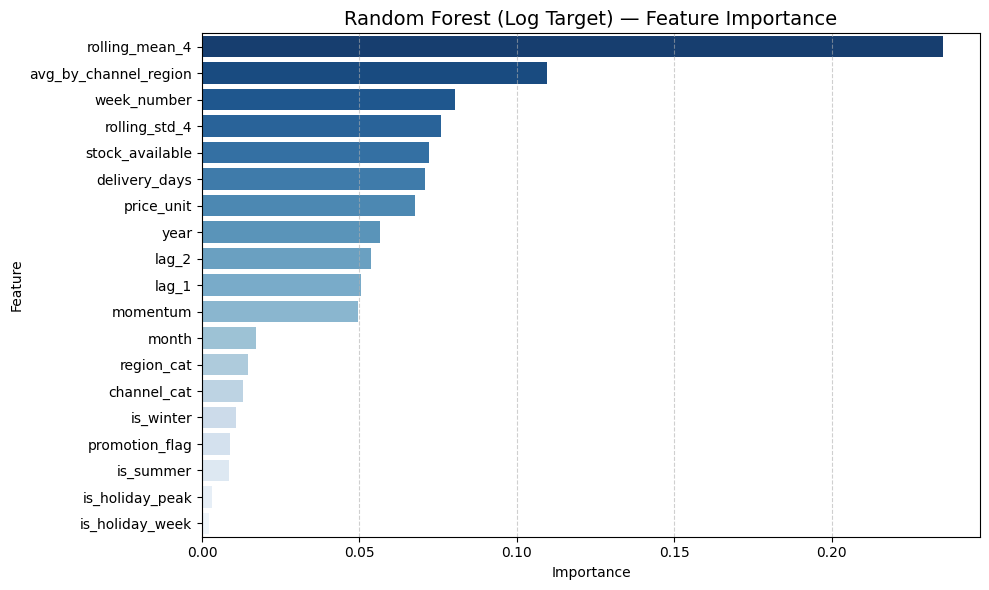

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Get feature importances from best Random Forest model
feature_importances = rf_model.feature_importances_
features = X_train_rf.columns

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    "feature": features,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="importance", y="feature", palette="Blues_r")
plt.title("Random Forest (Log Target) — Feature Importance", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## ➜ RF GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Log-transform target for training
y_train_rf_log = np.log1p(y_train_rf)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.8]
}

# Random Forest model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # still on log-scale!
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit model on log-transformed target
grid_search.fit(X_train_rf, y_train_rf_log)

# Show best hyperparameters and neg-MAE (log scale)
grid_search.best_params_, grid_search.best_score_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


({'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 100},
 -0.27370388659671824)

In [25]:
# Get best model
best_rf_log = grid_search.best_estimator_

# Predict and inverse transform
y_pred_best_rf_log = best_rf_log.predict(X_test_rf)
y_pred_best_rf = np.expm1(y_pred_best_rf_log)

# Evaluate
mae = mean_absolute_error(y_test_rf, y_pred_best_rf)
rmse = mean_squared_error(y_test_rf, y_pred_best_rf, squared=False)
r2 = r2_score(y_test_rf, y_pred_best_rf)

print("Best Random Forest (from GridSearch) — Evaluation on Original Scale:")
print("MAE:  ", round(mae, 2))
print("RMSE: ", round(rmse, 2))
print("R²:   ", round(r2, 3))

Best Random Forest (from GridSearch) — Evaluation on Original Scale:
MAE:   19.8
RMSE:  25.33
R²:    0.128


# 📊 8. Models Summary IV

| Model Variant                  | MAE     | RMSE    | R²        |
|-------------------------------|---------|---------|-----------|
| Baseline (Lag-1)              | 29.28   | 37.21   | −0.169    |
| LightGBM (basic)              | 21.41   | 27.51   | −0.030    |
| + `avg_by_channel_region`     | 20.87   | 26.40   | +0.052    |
| LightGBM (extended)           | 22.68   | 27.88   | −0.111    |
| LightGBM (log target)         | 20.69   | 26.60   | +0.038    |
| Random Forest                 | 20.55   | 25.67   | +0.104    |
| Random Forest (log target)    | 19.97   | 25.44   | +0.120    |
| Random Forest (tuned, log target) | **19.80** | **25.33** | **+0.128** |

>The tuned Random Forest with log-transformed target outperformed all previous models on all metrics.  
This confirms both the effectiveness of log-scaling and the impact of hyperparameter optimization — even for a robust algorithm like Random Forest.


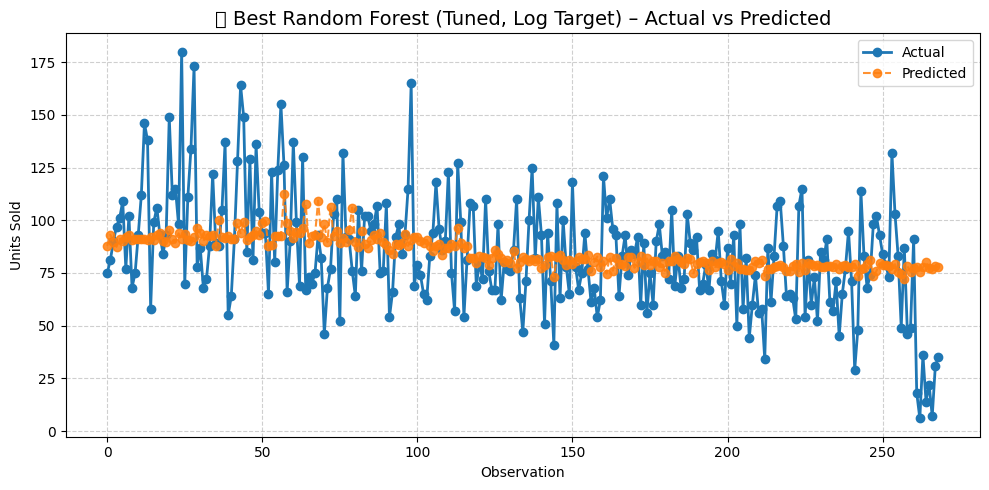

In [26]:
# Predict using the best model from GridSearch and inverse transform
y_pred_best_rf_log = best_rf_log.predict(X_test_rf)
y_pred_best_rf = np.expm1(y_pred_best_rf_log)

# Reset index for alignment
y_true = y_test_rf.reset_index(drop=True)
y_pred = pd.Series(y_pred_best_rf)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="Actual", marker='o', linewidth=2)
plt.plot(y_pred, label="Predicted", marker='o', linestyle='--', alpha=0.85)

plt.title("📈 Best Random Forest (Tuned, Log Target) – Actual vs Predicted", fontsize=14)
plt.xlabel("Observation")
plt.ylabel("Units Sold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


While this model achieves the best numeric performance across all metrics (MAE: 19.8, RMSE: 25.33, R²: 0.128), the plot clearly reveals a trade-off:

>  The predictions appear overly smoothed — failing to capture the real volatility and peaks in actual weekly demand.

This is a common side effect of:
- using log-transformed targets (which compress high values),
- ensemble tree models like Random Forest (which average across many splits),
- and the model's inherent bias toward conservative forecasts.

In practice, this could lead to underestimating critical spikes in demand — such as holiday periods or promotional campaigns.

---

# 💡❗ 9. Rethinking Our Approach: 

### Can Daily Data Do Better?

Despite extensive tuning and careful feature engineering, our best weekly-level model — a log-transformed Random Forest — still failed to capture demand peaks and retained relatively modest performance (R² = 0.128).

This led us to ask a different question:

> **What if the problem isn't the model — but the granularity of the data itself?**

Weekly demand is inherently volatile and sparse. Each week represents only one observation per SKU, limiting the model's ability to learn detailed behavioral patterns.

To test this hypothesis, we restructured the dataset at the **daily level** and kept `units_sold` as the prediction target.

The result? A surprising leap in model performance.

Let's walk through the new approach below 

In [27]:
df_final = pd.read_csv("/kaggle/input/fmcg-daily-sales-data-to-2022-2024/FMCG_2022_2024.csv")
df_final = df_final[df_final['sku'] == 'MI-006'].copy()
df_final.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


In [28]:
# adding features

df_final['date'] = pd.to_datetime(df_final['date'])
df_final['year'] = df_final['date'].dt.year
df_final['month'] = df_final['date'].dt.month
df_final['day_of_week'] = df_final['date'].dt.dayofweek    # Monday = 0, Sunday = 6
df_final['week'] = df_final['date'] - pd.to_timedelta(df_final['day_of_week'], unit='d')
df_final[['date', 'year', 'month', 'week', 'day_of_week']].head()

,date,year,month,week,day_of_week
0,2022-01-21,2022,1,2022-01-17,4
1,2022-01-21,2022,1,2022-01-17,4
2,2022-01-21,2022,1,2022-01-17,4
3,2022-01-21,2022,1,2022-01-17,4
4,2022-01-21,2022,1,2022-01-17,4


## 💡 LightGBM - daily

In [29]:
df_lgbm = df_final.sort_values("date").reset_index(drop=True)
feature_cols = [
    "price_unit", "promotion_flag", "stock_available", "delivery_days",
    "month", "day_of_week"
]
target_col = "units_sold"

In [30]:
X_train, X_test, y_train, y_test = time_split_by_week(
    df=df_lgbm,
    feature_cols=feature_cols,
    target_col=target_col,
    split_ratio=0.8
)

Cutoff week for split: 2024-06-03
🟩 Train weeks: 2022-01-17 – 2024-05-27
🟥 Test weeks:  2024-06-03 – 2024-12-30


In [31]:
model_lgbm, y_pred_lgbm = train_and_evaluate_lgbm(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 6617, number of used features: 6
[LightGBM] [Info] Start training from score 16.474535
 LightGBM Regressor Results:
MAE:  3.57
RMSE: 5.04
R²:   0.603


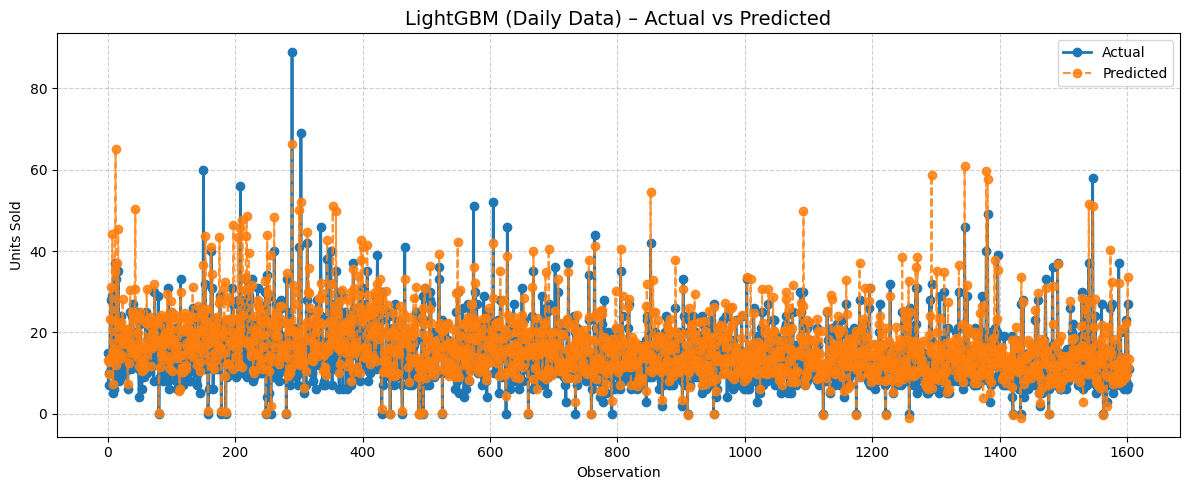

In [32]:
# Reset index for clean plotting
y_true = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred_lgbm)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_true, label="Actual", marker='o', linewidth=2)
plt.plot(y_pred, label="Predicted", marker='o', linestyle='--', alpha=0.85)

plt.title("LightGBM (Daily Data) – Actual vs Predicted", fontsize=14)
plt.xlabel("Observation")
plt.ylabel("Units Sold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


> ...Lets see how it presents weekly..

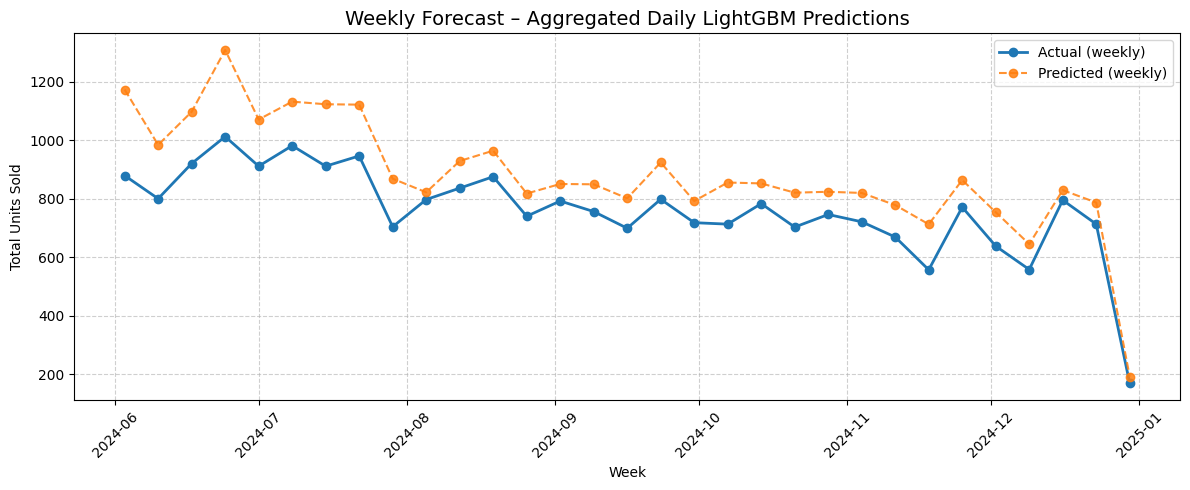

In [33]:
df_plot = pd.DataFrame({
    'week': df_lgbm.loc[X_test.index, 'week'].values,
    'actual': y_test.values,
    'predicted': y_pred_lgbm
})


df_weekly = df_plot.groupby('week')[['actual', 'predicted']].sum().reset_index()

# Evaluate
plt.figure(figsize=(12, 5))
plt.plot(df_weekly['week'], df_weekly['actual'], label='Actual (weekly)', marker='o', linewidth=2)
plt.plot(df_weekly['week'], df_weekly['predicted'], label='Predicted (weekly)', marker='o', linestyle='--', alpha=0.85)

plt.title("Weekly Forecast – Aggregated Daily LightGBM Predictions", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


>The plot above shows that our daily-level LightGBM model not only performs well numerically — it also aligns closely with weekly demand patterns.
>
>By aggregating daily predictions to weekly totals, we bridge the gap between high-frequency modeling and business-level decision making.  
The model captures both seasonality and short-term fluctuations without the volatility and noise seen in raw weekly models.
>
> **This confirms that modeling on daily data, then rolling up, outperforms weekly-level models both visually and analytically.**


## 💡 Insight from Further Exploration: Daily Data Performs Better

After our main effort focused on **weekly demand forecasting**, we revisited the problem using **daily-level data** and a simple regression model targeting `units_sold`.

Surprisingly, this alternative approach produced significantly **better results** — both in terms of accuracy and model stability.

---

###  Results Comparison

| Data Granularity | Target             | R²     | MAE   | RMSE  |
| ---------------- | ------------------ | ------ | ----- | ----- |
| **Daily**        | `units_sold`       | 0.603  | 3.57  | 5.04  |
| Daily            | `target_next_week` | -0.551 | 58.01 | 73.94 |
| Weekly           | `units_sold`       | 0.170  | 18.78 | 22.92 |
| Weekly           | `target_next_week` | -0.406 | 25.71 | 32.15 |

As the table shows, using **daily `units_sold` as target** led to **60% explained variance** and significantly lower error metrics — outperforming all weekly models.

---

###  Why Daily Data Helped

* Daily data offers **more granularity** — allowing the model to learn effects like:

  * day-of-week seasonality,
  * weekend patterns,
  * holidays and promotions,
  * short-term trends.

* It also provides a **larger training set** (\~6,000+ rows vs. \~1,000 in weekly format), improving generalization and model robustness.



While our initial focus was on weekly modeling, further exploration revealed that **daily-level modeling is significantly more effective**.
This insight allowed us to improve forecast accuracy dramatically and better align with the dynamic nature of FMCG sales.

> **Lesson learned:** Granular data can uncover patterns that aggregated views may hide — and modeling decisions should always be guided by empirical validation.


📎 Connect: [LinkedIn](https://www.linkedin.com/in/beata-faron-24764832/) | [GitHub](https://github.com/...)  
